# Dependencies

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'



In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
from albumentations.pytorch import ToTensor
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma, OneOf, Resize,
    ToFloat, ShiftScaleRotate, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CenterCrop,
    IAAAdditiveGaussianNoise, GaussNoise, OpticalDistortion, RandomSizedCrop, VerticalFlip, Normalize, Cutout, CoarseDropout, RandomRotate90
)

# GroupKFold splitting

I think group splitting by image_name is really important for correct validation in this competition ;) 

In [4]:
%%time

dataset = []

for label, kind in enumerate(['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']):
    for path in glob('/home/data/alaska/Cover/*.jpg'):
        dataset.append({
            'kind': kind,
            'image_name': path.split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=5)

dataset.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

CPU times: user 2.88 s, sys: 0 ns, total: 2.88 s
Wall time: 2.88 s


In [5]:
dataset.label.value_counts()

3    75000
2    75000
1    75000
0    75000
Name: label, dtype: int64

In any case original dataframe with splitting:

In [6]:
# dataset = pd.read_csv('../input/alaska2-public-baseline/groupkfold_by_shonenkov.csv')

# Simple Augs: Flips

In [7]:
def get_train_transforms():
    return Compose([
        VerticalFlip(p=0.5),
    HorizontalFlip(p=0.5),
    RandomRotate90(p=0.5),
    OneOf([
        Cutout(max_h_size=50,max_w_size=50),
        CoarseDropout(max_height=50, max_width=50)], p=0.5),
    Normalize(mean=(0.485,0.456,0.406),
              std=(0.229,0.224,0.225),max_pixel_value=255.0),
    #ToFloat(max_value=255),
    ToTensor()
], p=1)

def get_valid_transforms():
    return Compose([
    #ToFloat(max_value=255),
    Normalize(mean=(0.485,0.456,0.406),
              std=(0.229,0.224,0.225),max_pixel_value=255.0),
    ToTensor()
], p=1)

# Dataset

In [8]:
DATA_ROOT_PATH = '/home/data/alaska'

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{kind}/{image_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        target = onehot(4, label)
        return image, target

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

In [9]:
fold_number = 1

train_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] != fold_number].kind.values,
    image_names=dataset[dataset['fold'] != fold_number].image_name.values,
    labels=dataset[dataset['fold'] != fold_number].label.values,
    transforms=get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == fold_number].kind.values,
    image_names=dataset[dataset['fold'] == fold_number].image_name.values,
    labels=dataset[dataset['fold'] == fold_number].label.values,
    transforms=get_valid_transforms(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


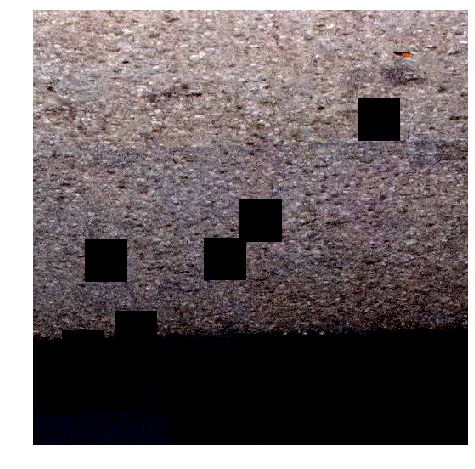

In [10]:
image, target = train_dataset[0]
numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
ax.set_axis_off()
ax.imshow(numpy_image);

# Metrics

In [11]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def alaska_weighted_auc(y_true, y_valid):
    """
    https://www.kaggle.com/anokas/weighted-auc-metric-updated
    """
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])

    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)

    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        # pdb.set_trace()

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min  # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric

    return competition_metric / normalization
        
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = alaska_weighted_auc(self.y_true, self.y_pred)
    
    @property
    def avg(self):
        return self.score

# Label Smoothing

In [12]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.05):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

# Fitter

In [13]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = 'public_moreaugs_imagenrom_f1/'
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**-5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = LabelSmoothing().to(self.device)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if final_scores.avg > self.best_summary_loss:
                self.best_summary_loss = final_scores.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-5]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                final_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device).float()
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            
            final_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

# EfficientNet

In [14]:
from efficientnet_pytorch import EfficientNet

def get_net():
    net = EfficientNet.from_pretrained('efficientnet-b4')
    net._fc = nn.Linear(in_features=1792, out_features=4, bias=True)
    return net

net = get_net().cuda()

Loaded pretrained weights for efficientnet-b4


# Config

In [15]:
class TrainGlobalConfig:
    num_workers = 16
    batch_size = 24 
    n_epochs = 50
    lr = 0.001

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

# Class Balance "on fly" from [@CatalystTeam](https://github.com/catalyst-team/catalyst)

In [16]:
from catalyst.data.sampler import BalanceClassSampler

def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

# Training

I have used 1xV100 for training model, in kaggle kernel it works also. You can make fork and check it, but I would like to share with you my logs

In [17]:
run_training()

Fitter prepared. Device is cuda:0

2020-07-05T09:34:43.237637
LR: 0.001
[RESULT]: Train. Epoch: 0, summary_loss: 1.12766, final_score: 0.75228, time: 8138.89728
[RESULT]: Val. Epoch: 0, summary_loss: 1.03001, final_score: 0.79131, time: 581.23065

2020-07-05T12:00:03.924812
LR: 0.001
[RESULT]: Train. Epoch: 1, summary_loss: 1.02571, final_score: 0.79044, time: 8082.93161
[RESULT]: Val. Epoch: 1, summary_loss: 0.98924, final_score: 0.80825, time: 582.54148

2020-07-05T14:24:30.216064
LR: 0.001
[RESULT]: Train. Epoch: 2, summary_loss: 0.99335, final_score: 0.80234, time: 8078.93452
[RESULT]: Val. Epoch: 2, summary_loss: 0.96854, final_score: 0.81466, time: 576.73218

2020-07-05T16:48:46.503563
LR: 0.001
[RESULT]: Train. Epoch: 3, summary_loss: 0.97414, final_score: 0.80962, time: 8151.74007
[RESULT]: Val. Epoch: 3, summary_loss: 0.93163, final_score: 0.82617, time: 584.23054

2020-07-05T19:14:23.109271
LR: 0.001
[RESULT]: Train. Epoch: 4, summary_loss: 0.96152, final_score: 0.81629, time

# Inference

In [19]:
checkpoint = torch.load('public_moreaugs_imagenrom_f1/best-checkpoint-047epoch.bin')
net.load_state_dict(checkpoint['model_state_dict']);
net.eval();

In checkpoint you can find states for optimizer and scheduler if you need

In [20]:
checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_summary_loss', 'epoch'])

In [21]:
class DatasetSubmissionRetriever(Dataset):

    def __init__(self, image_names, transforms=None):
        super().__init__()
        self.image_names = image_names
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_name = self.image_names[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/Test/{image_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image_name, image

    def __len__(self) -> int:
        return self.image_names.shape[0]

In [22]:
dataset = DatasetSubmissionRetriever(
    image_names=np.array([path.split('/')[-1] for path in glob('/home/data/alaska/Test/*.jpg')]),
    transforms=get_valid_transforms(),
)


data_loader = DataLoader(
    dataset,
    batch_size=5,
    shuffle=False,
    num_workers=16,
    drop_last=False,
)

In [23]:
DATA_ROOT_PATH = '/home/data/alaska'

In [24]:
%%time
tta = True
result = {'Id': [], 'Label': []}
for step, (image_names, images) in enumerate(data_loader):
    print(step, end='\r')
    #images = images.to(device, dtype=torch.float)
    inputs_flip_vert = images.flip(2)
    inputs_flip_hor = images.flip(3)
    outputs = net(images.cuda())
    outputs_vert = net(inputs_flip_vert.cuda())
    outputs_hor = net(inputs_flip_hor.cuda())
    #y_pred = net(images.cuda())
    y_pred = 1 - nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,0]
    y_pred_vert = 1 - nn.functional.softmax(outputs_vert, dim=1).data.cpu().numpy()[:,0]
    y_pred_hor = 1 - nn.functional.softmax(outputs_hor, dim=1).data.cpu().numpy()[:,0]
    result['Id'].extend(image_names)
    if tta:
        result['Label'].extend(np.mean([y_pred, y_pred_vert, y_pred_hor], axis=0))
    else:
        result['Label'].extend(y_pred)

CPU times: user 36min 21s, sys: 24 s, total: 36min 45s
Wall time: 3min 23s


In [25]:
submission = pd.DataFrame({'Id':result['Id'], 'Label':result['Label']})
submission.to_csv('effv4_47_epoch_withTTA_moreaugs_imagenetnorm_LCV_92651.csv', index=False)
submission.head()

,Id,Label
0,1032.jpg,0.452246
1,2713.jpg,0.287754
2,0544.jpg,0.826904
3,2952.jpg,0.688912
4,4078.jpg,0.537673


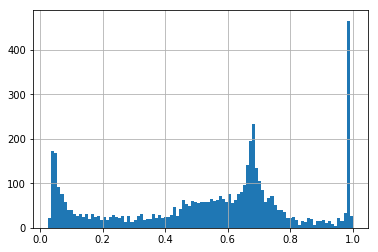

In [26]:
submission['Label'].hist(bins=100);

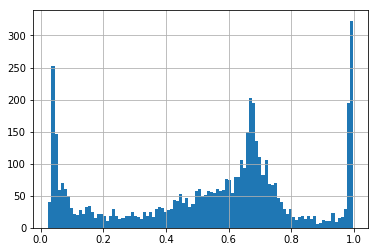

In [50]:
submission['Label'].hist(bins=100);

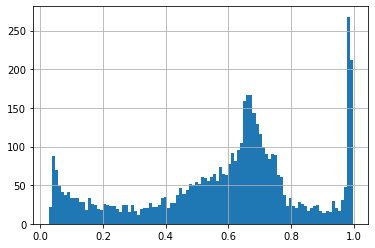

In [23]:
submission['Label'].hist(bins=100);

## Predict by several epochs

In [20]:
def predict_by_model(net):
    result = {'Id': [], 'Label': []}
    for step, (image_names, images) in enumerate(data_loader):
        print(step, end='\r')
        #images = images.to(device, dtype=torch.float)
        inputs_flip_vert = images.flip(2)
        inputs_flip_hor = images.flip(3)
        outputs = net(images.cuda())
        outputs_vert = net(inputs_flip_vert.cuda())
        outputs_hor = net(inputs_flip_hor.cuda())
        #y_pred = net(images.cuda())
        y_pred = 1 - nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,0]
        y_pred_vert = 1 - nn.functional.softmax(outputs_vert, dim=1).data.cpu().numpy()[:,0]
        y_pred_hor = 1 - nn.functional.softmax(outputs_hor, dim=1).data.cpu().numpy()[:,0]
        result['Id'].extend(image_names)
        result['Label'].extend(np.mean([y_pred, y_pred_vert, y_pred_hor], axis=0))
    return result

In [29]:
model_paths = ['Models/public_and_my/best-checkpoint-042epoch.bin',
              'Models/public_and_my/best-checkpoint-038epoch.bin',
              'Models/public_and_my/best-checkpoint-037epoch.bin',
               'Models/public_and_my/best-checkpoint-036epoch.bin',
              'Models/public_and_my/best-checkpoint-033epoch_my.bin'
              ]

In [30]:
all_preds = []
for i, model_path in enumerate(model_paths):
    print(i)
    net = get_net().cuda()
    checkpoint = torch.load(model_path)
    net.load_state_dict(checkpoint['model_state_dict']);
    net = net.eval();
    
    result = predict_by_model(net)
    all_preds.append(result['Label'])
all_preds = np.array(all_preds)
#print(f'weighted auc {alaska_weighted_auc(a, all_preds[0])}')
s = np.sum([2**i for i in range(len(all_preds))])
all_preds = np.sum([all_preds[i]*2**(len(all_preds) -i - 1) for i in range(len(all_preds))], axis=0) / s

0
Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

199
Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

299
Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

399
Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

499
Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [31]:
result['Label'] = all_preds

In [32]:
result['Label'] 

array([0.4163466 , 0.33576334, 0.6210755 , ..., 0.7472304 , 0.3760011 ,
       0.5534276 ], dtype=float32)

In [33]:
submission = pd.DataFrame({'Id':result['Id'], 'Label':result['Label']})
submission.to_csv('submission_public_effv4_local92527_TTA_5epochs.csv', index=False)
submission.head()

,Id,Label
0,1032.jpg,0.416347
1,2713.jpg,0.335763
2,0544.jpg,0.621076
3,2952.jpg,0.666710
4,4078.jpg,0.673558


In [27]:
len(submission)

5000